# Classification model for air quality prediction in time

⚠️ Some parts of this notebook are the same as `regression_main.ipynb`. The traffic part is the exact same, so is still regression. I suppressed most of the output of the traffic prediction model training/validation as it is duplicate.

The classification part intervenes in the air quality prediction.

## Classification with Data Balancing

This notebook applies data balacing tecniques (oversampling/undersampling) to handle class imbalance in the dataset before training classification modeles.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, cohen_kappa_score
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor, LGBMClassifier
import plotly.graph_objects as go
from scipy.stats import mode
import seaborn as sns


Loading the dataset for classification

In [2]:
df=pd.read_pickle("created_dataset_classes.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16081 entries, 0 to 16080
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           16081 non-null  object        
 1   hour           16081 non-null  int32         
 2   traffic_z0     16081 non-null  float64       
 3   traffic_z1     16081 non-null  float64       
 4   traffic_z3     16081 non-null  float64       
 5   traffic_z4     16081 non-null  float64       
 6   traffic_z5     16081 non-null  float64       
 7   traffic_z6     16081 non-null  float64       
 8   traffic_z7     16081 non-null  float64       
 9   traffic_z8     16081 non-null  float64       
 10  station_4      16081 non-null  object        
 11  station_43     16081 non-null  object        
 12  station_44     16081 non-null  object        
 13  station_54     16081 non-null  object        
 14  station_57     16081 non-null  object        
 15  station_58     1608

We will predict both traffic and air quality in the future. Here is the number of hours in the future the prediction will be made.

In [3]:
forecast_h = 12 # Prediction will be made for forecast_h hours in the future

# Predicting traffic

In [4]:
# Identifying the 'traffic_zN' columns
traffic_cols = [c for c in df.columns if c.startswith("traffic_")]

# Creating the target value (value forecast_h hours after) for every traffic area
for col in traffic_cols:
    df[f"target_{col}"] = df[col].shift(-forecast_h)

# This functions add lags (values from previous hours) and rolls (previous rolling means over time windows)
def add_lags_and_rolls(df, cols, lags=[1, 2, 3, 6, 12], rolls=[3, 6, 12]):
    for col in cols:
        for lag in lags:
            df[f"{col}_lag{lag}"] = df[col].shift(lag)
        for w in rolls:
            df[f"{col}_roll{w}"] = df[col].rolling(window=w).mean()
    return df

df = add_lags_and_rolls(df, traffic_cols)
df["dayofweek"] = df["datetime_hour"].dt.dayofweek
df = df.dropna().reset_index(drop=True)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16057 entries, 0 to 16056
Data columns (total 98 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               16057 non-null  object        
 1   hour               16057 non-null  int32         
 2   traffic_z0         16057 non-null  float64       
 3   traffic_z1         16057 non-null  float64       
 4   traffic_z3         16057 non-null  float64       
 5   traffic_z4         16057 non-null  float64       
 6   traffic_z5         16057 non-null  float64       
 7   traffic_z6         16057 non-null  float64       
 8   traffic_z7         16057 non-null  float64       
 9   traffic_z8         16057 non-null  float64       
 10  station_4          16057 non-null  object        
 11  station_43         16057 non-null  object        
 12  station_44         16057 non-null  object        
 13  station_54         16057 non-null  object        
 14  statio

Training of one model per zone

In [5]:
models_traffic = {}
scalers_traffic = {}
for col in traffic_cols:
    # Features : lags/rolling de la zone + temporel
    feature_cols = [c for c in df.columns if c.startswith(f"{col}_") or c in ["hour", "dayofweek"]]
    X = df[feature_cols]
    y = df[f"target_{col}"]

    # Split train/test
    split_idx = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Normalisation
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    scalers_traffic[col] = scaler

    # Model
    model = LGBMRegressor(n_estimators=300, learning_rate=0.05, random_state=42, verbose=-1) # verbose=-1 for no output
    model.fit(X_train_scaled, y_train)
    models_traffic[col] = model

"""     Suppress the testing output
    # Metrics
    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    #print(f"[TRAFFIC] {col}: MAE = {mae:.2f}, R² = {r2:.3f}")

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df["datetime_hour"].iloc[split_idx:],
        y=y_test,
        mode='lines',
        name='VReal values',
        line=dict(color='blue')
    ))
    fig.add_trace(go.Scatter(
        x=df["datetime_hour"].iloc[split_idx:],
        y=y_pred,
        mode='lines',
        name='Prédictions',
        line=dict(color='red', dash='dash')
    ))
    fig.update_layout(
        title=f"Traffic prediction in ({col}) for +{forecast_h}h",
        xaxis_title="Date",
        yaxis_title="Traffic",
        hovermode="x unified",
        template="plotly_white"
    )
    fig.show() """


'     Suppress the testing output\n    # Metrics\n    y_pred = model.predict(X_test_scaled)\n    mae = mean_absolute_error(y_test, y_pred)\n    r2 = r2_score(y_test, y_pred)\n    #print(f"[TRAFFIC] {col}: MAE = {mae:.2f}, R² = {r2:.3f}")\n\n    fig = go.Figure()\n    fig.add_trace(go.Scatter(\n        x=df["datetime_hour"].iloc[split_idx:],\n        y=y_test,\n        mode=\'lines\',\n        name=\'VReal values\',\n        line=dict(color=\'blue\')\n    ))\n    fig.add_trace(go.Scatter(\n        x=df["datetime_hour"].iloc[split_idx:],\n        y=y_pred,\n        mode=\'lines\',\n        name=\'Prédictions\',\n        line=dict(color=\'red\', dash=\'dash\')\n    ))\n    fig.update_layout(\n        title=f"Traffic prediction in ({col}) for +{forecast_h}h",\n        xaxis_title="Date",\n        yaxis_title="Traffic",\n        hovermode="x unified",\n        template="plotly_white"\n    )\n    fig.show() '

# Predicting air quality
First with real traffic values. (Later I will use the predicted ones)

In [6]:
print(df.info())

# Identify the station cols
station_cols = [c for c in df.columns if c.startswith("station_")]
weather_cols = ["temperature", "wind_u", "wind_v", "precipitation", "is_raining", "humidity", "pressure", "cloud_cover"]
weather_cols = [c for c in weather_cols if c in df.columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16057 entries, 0 to 16056
Data columns (total 98 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               16057 non-null  object        
 1   hour               16057 non-null  int32         
 2   traffic_z0         16057 non-null  float64       
 3   traffic_z1         16057 non-null  float64       
 4   traffic_z3         16057 non-null  float64       
 5   traffic_z4         16057 non-null  float64       
 6   traffic_z5         16057 non-null  float64       
 7   traffic_z6         16057 non-null  float64       
 8   traffic_z7         16057 non-null  float64       
 9   traffic_z8         16057 non-null  float64       
 10  station_4          16057 non-null  object        
 11  station_43         16057 non-null  object        
 12  station_44         16057 non-null  object        
 13  station_54         16057 non-null  object        
 14  statio

Creation of the `target column`: this is the value we will try to predict for a given hour. It is the air quality labeled by station 4 in `forecast_h` hours.

In [7]:
# Target: Can be either the mean of all the stations, or one specific station.


target, target_label = df[['station_4']], "Air quality in station 4"

In [8]:
df["air_quality_selected"] = target
df["target_air_quality"] = df["air_quality_selected"].shift(-forecast_h)



# We can't add rolls of classes as in add_lags_and_rolls, so instead I will add modes (most frequent label over a period)
def add_lags_and_modes(df, cols, lags=[1, 2, 3, 6, 12], windows=[3, 6, 12]):
    for col in cols:
        # Adding lags
        for lag in lags:
            df[f"{col}_lag{lag}"] = df[col].shift(lag)
        # Adding rolling modes
        for w in windows:
            df[f"{col}_mode{w}"] = None  # Init a column to store the mode
            for i in range(len(df)):
                start = max(0, i - w + 1)
                window = df[col].iloc[start:i+1]                
                # calculer le mode avec pands
                mode_result = window.mode()
                if not mode_result.empty:
                    current_mode = mode_result.iloc[0]
                    df.at[i, f"{col}_mode{w}"] = current_mode
                else:
                    # Utiliser la dernière valeur valide
                    last_valid = window.last_valid_index()
                    if last_valid is not None:
                        df.at[i, f"{col}_mode{w}"] = df[col].iloc[last_valid]
                        print(f"    Utilisation de la dernière valeur valide: {df[col].iloc[last_valid]}")
    return df


# Create Lags/rolling for air_quality + weather
df = add_lags_and_modes(df, ["air_quality_selected"] + weather_cols)
df = df.dropna().reset_index(drop=True) # By creating lags, we will loose forecast_h rows

"""# Ajout des prédictions de trafic (ou des données réelles)
use_predicted_traffic = True  # Option true/False
 if use_predicted_traffic:
    for col in traffic_cols:
        # Prédire le trafic pour toute la période (exemple simplifié..)
        feature_cols = [c for c in df.columns if c.startswith(f"{col}_") or c in ["hour", "dayofweek"]]
        X_traffic = df[feature_cols]
        X_traffic_scaled = scalers_traffic[col].transform(X_traffic)
        df[f"predicted_{col}"] = models_traffic[col].predict(X_traffic_scaled)
    traffic_features = [f"predicted_{col}" for col in traffic_cols]
else:
    traffic_features = traffic_cols """
traffic_features = traffic_cols

In [9]:
# Get the created features names
feature_cols_air = (
    traffic_features +
    [c for c in df.columns if any(x in c for x in ["_lag", "_mode"]) and "air_quality" in c] +
    [c for c in df.columns if any(x in c for x in ["_lag", "_mode"]) and c.split("_")[0] in weather_cols] +
    ["hour", "dayofweek"]
)

print(feature_cols_air)

['traffic_z0', 'traffic_z1', 'traffic_z3', 'traffic_z4', 'traffic_z5', 'traffic_z6', 'traffic_z7', 'traffic_z8', 'air_quality_selected_lag1', 'air_quality_selected_lag2', 'air_quality_selected_lag3', 'air_quality_selected_lag6', 'air_quality_selected_lag12', 'air_quality_selected_mode3', 'air_quality_selected_mode6', 'air_quality_selected_mode12', 'temperature_lag1', 'temperature_lag2', 'temperature_lag3', 'temperature_lag6', 'temperature_lag12', 'temperature_mode3', 'temperature_mode6', 'temperature_mode12', 'precipitation_lag1', 'precipitation_lag2', 'precipitation_lag3', 'precipitation_lag6', 'precipitation_lag12', 'precipitation_mode3', 'precipitation_mode6', 'precipitation_mode12', 'humidity_lag1', 'humidity_lag2', 'humidity_lag3', 'humidity_lag6', 'humidity_lag12', 'humidity_mode3', 'humidity_mode6', 'humidity_mode12', 'pressure_lag1', 'pressure_lag2', 'pressure_lag3', 'pressure_lag6', 'pressure_lag12', 'pressure_mode3', 'pressure_mode6', 'pressure_mode12', 'hour', 'dayofweek']


Splitting the dataset into a training dataset and testing other.
Since I need continous time, I can not pick randomly to fill these two new datasets. I chose to take the first 80% of the timeframe as training, and the remaining part as testing. This has some flaws (for example, the seasons change), I will try other ways later.



<span style="color:red">Now this cell balances good/medium/bad in the training dataset to avoid bias.</soan>

In [10]:
import pandas as pd
import numpy as np


# 1. Initial Split (Chronological)
split_idx = int(len(df) * 0.8)
df_train = df.iloc[:split_idx].copy()
df_test = df.iloc[split_idx:].copy()
df_train_snapshot = df_train['target_air_quality']
print("Training Class Distribution in original training DF:")
print(df_train_snapshot.value_counts())


target_col = 'target_air_quality'
block_size = 30

# 2. Identify the target count (smallest class in original training set)
min_class_count = df_train[target_col].value_counts().min()
print(f"Target count per class: {min_class_count}")

# 3. Function to get all indices of a class PLUS their 30h history
def get_all_indices_with_history(data, target_class, size):
    class_indices = data.index[data[target_col] == target_class].tolist()
    all_indices = []
    for idx in class_indices:
        # Get the 30h block ending at this index
        block = list(range(idx - (size - 1), idx + 1))
        all_indices.extend(block)
    # Filter to only include indices that exist in df_train
    return [i for i in all_indices if i in data.index]

# 4. Build a pool of indices that include the context for every occurrence
all_possible_indices = []
for label in ['good', 'medium', 'bad']:
    all_possible_indices.extend(get_all_indices_with_history(df_train, label, block_size))

# Remove duplicates (important for overlapping blocks)
unique_indices = sorted(list(set(all_possible_indices)))
df_temp = df_train.loc[unique_indices]

# 5. Perfect Balancing: Downsample each class to match min_class_count
balanced_dfs = []
for label in ['good', 'medium', 'bad']:
    # Get all rows that are currently labeled as this class
    class_subset = df_temp[df_temp[target_col] == label]
    
    # Randomly sample exactly min_class_count rows
    # if class_subset is smaller than min_class_count (rare), we take all
    n_to_sample = min(len(class_subset), min_class_count)
    balanced_dfs.append(class_subset.sample(n=n_to_sample, random_state=42))

# Combine and sort by index to maintain some temporal order
df_train_balanced = pd.concat(balanced_dfs).sort_index()

# 6. Final Assignment
X_train = df_train_balanced[feature_cols_air]
y_train = df_train_balanced[target_col]

X_test = df_test[feature_cols_air]
y_test = df_test[target_col]

print("\nFinal Training Class Distribution:")
print(y_train.value_counts())

Training Class Distribution in original training DF:
target_air_quality
good      6078
medium    5337
bad       1411
Name: count, dtype: int64
Target count per class: 1411

Final Training Class Distribution:
target_air_quality
bad       1411
medium    1411
good      1411
Name: count, dtype: int64


## Encoding the labels

We need to encode the labels as integers for processing

In [11]:
from sklearn.preprocessing import LabelEncoder

le_y = LabelEncoder()
# Encode y_train
y_train_encoded = le_y.fit_transform(y_train)

# Encode X_train and X_test
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

for col in X_train_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_train_encoded.loc[:, col] = le.fit_transform(X_train_encoded[col])
    # Convert the column to int type (not automatic)
    X_train_encoded[col] = X_train_encoded[col].astype(int)

for col in X_test_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_test_encoded.loc[:, col] = le.fit_transform(X_test_encoded[col])
    # Convert the column to int type (not automatic)
    X_test_encoded[col] = X_test_encoded[col].astype(int)


# No need to encode y_train, because I will decode the prediction.

Now, the training dataset (X_train, y_train) is encoded. So the prediction will also be encoded

In [12]:
# Actual model for air quality prediction
model_air = LGBMClassifier(n_estimators=500, learning_rate=0.05, random_state=42)
model_air.fit(X_train_encoded, y_train_encoded)

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


PREDICT [1 2 1 ... 1 1 1]
decoded ['good' 'medium' 'good' ... 'good' 'good' 'good']
Unique labels in y_test: ['bad' 'good' 'medium']
Unique labels in y_pred: ['bad' 'good' 'medium']
Accuracy = 0.557, Precision = 0.560, Recall = 0.557, F1 = 0.531, Kappa = 0.224

Confusion Matrix:
[[ 138   90   64]
 [ 129 1372  206]
 [ 295  638  275]]

Classification Report:
              precision    recall  f1-score   support

         bad       0.25      0.47      0.32       292
        good       0.65      0.80      0.72      1707
      medium       0.50      0.23      0.31      1208

    accuracy                           0.56      3207
   macro avg       0.47      0.50      0.45      3207
weighted avg       0.56      0.56      0.53      3207



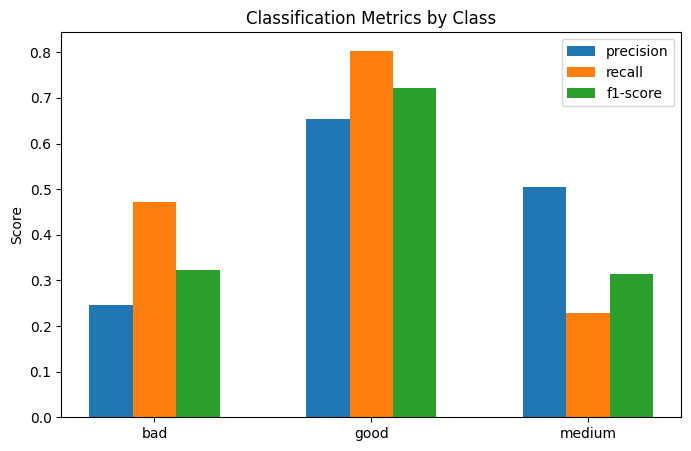

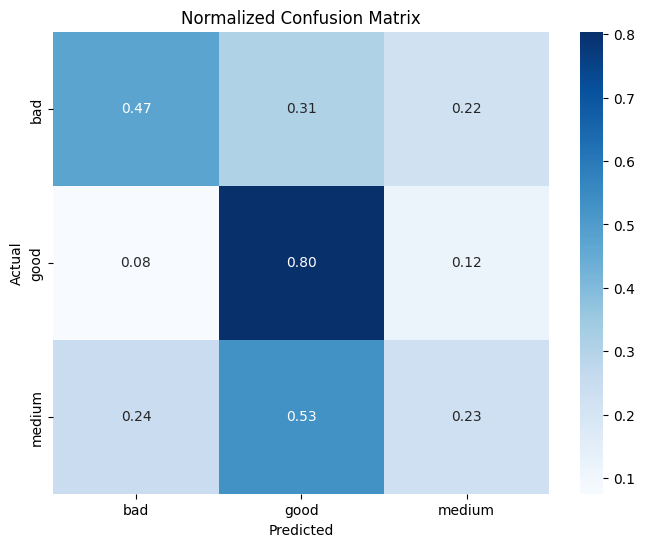

In [17]:

# Predicitng
y_pred_encoded = model_air.predict(X_test_encoded)


print("PREDICT", y_pred_encoded)
# Decoding
y_pred = le_y.inverse_transform(y_pred_encoded) # As labels
print("decoded", y_pred)

# Metrics
print("Unique labels in y_test:", np.unique(y_test))
print("Unique labels in y_pred:", np.unique(y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Use 'macro' or 'micro' if needed
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)

print(f"Accuracy = {accuracy:.3f}, Precision = {precision:.3f}, Recall = {recall:.3f}, F1 = {f1:.3f}, Kappa = {kappa:.3f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Plot


metrics = ['precision', 'recall', 'f1-score']
classes = report_df.index[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
width = 0.2
x = np.arange(len(classes))

for i, metric in enumerate(metrics):
    ax.bar(x + i * width, report_df.loc[classes, metric], width, label=metric)

ax.set_xticks(x + width)
ax.set_xticklabels(classes)
ax.set_ylabel("Score")
ax.set_title("Classification Metrics by Class")
ax.legend()
plt.show()


from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=le_y.classes_, yticklabels=le_y.classes_)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


